# 17 - SIFT SfM Class Pipeline

Notebook mit `SFM_Sift` als sauberem, erweiterbarem Wrapper fuer Dataset-Load, Prediction, Validation und Submission-Export.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from pathlib import Path
import sys

import pandas as pd

def find_project_root() -> Path:
    candidates = [Path.cwd(), Path.cwd().parent, Path('.').resolve(), Path('..').resolve()]
    seen = set()
    for cand in candidates:
        root = cand.resolve()
        key = str(root)
        if key in seen:
            continue
        seen.add(key)
        if (root / 'data' / 'data').exists():
            return root
    raise FileNotFoundError('Could not find project root containing data/data.')

PROJECT_ROOT = find_project_root()
SRC_ROOT = PROJECT_ROOT / 'src'
if str(SRC_ROOT) not in sys.path:
    sys.path.insert(0, str(SRC_ROOT))

from gdloc import SFM_Sift, SIFTSFMConfig

DATA_ROOT = PROJECT_ROOT / 'data' / 'data'

print('project_root:', PROJECT_ROOT)
print('src_root:', SRC_ROOT)
print('data_root:', DATA_ROOT)


project_root: /home/rupert/projects/gnss-denied-localization
src_root: /home/rupert/projects/gnss-denied-localization/src
data_root: /home/rupert/projects/gnss-denied-localization/data/data


In [2]:
cfg = SIFTSFMConfig(
    image_max_side=1000,
    preprocess_mode='gray_clahe',
    sift_nfeatures=6500,
    sift_contrast_thr=0.03,
    sift_edge_thr=12.0,
    sift_sigma=1.6,
    sift_ratio_thr=0.78,
)

sfm = SFM_Sift(
    train_images=DATA_ROOT / 'train_data' / 'train_images',
    test_images=DATA_ROOT / 'test_data' / 'test_images',
    train_cam_csv=DATA_ROOT / 'train_data' / 'train_cam.csv',
    test_cam_csv=DATA_ROOT / 'test_data' / 'test_cam.csv',
    train_pos_csv=DATA_ROOT / 'train_data' / 'train_pos.csv',
    map_path=DATA_ROOT / 'map.png',
    config=cfg,
)


In [3]:
sfm.load_dataset()

print('train frames:', len(sfm.train_ids))
print('test frames:', len(sfm.test_ids))
print('test ranges:', sfm.test_ranges)

if sfm.calib_df is not None:
    display(sfm.calib_df.head(10))
if sfm.coef_df is not None:
    display(sfm.coef_df)


train frames: 305
test frames: 136
test ranges: [(1, 12), (42, 44), (53, 56), (65, 68), (2468, 2527), (2663, 2674), (2705, 2716), (2747, 2758), (2789, 2800), (2832, 2836)]


,id0,id1,matches,affine_inliers,sfm_inliers,success,gt_dx,gt_dy,tx,ty,rot_deg,scale
0,13,14,889,520,717,True,12.100219,282.643468,-1.536253,-365.835768,0.342588,0.971274
1,14,15,1033,673,1022,True,11.402862,283.176780,-14.654605,-367.882534,0.126208,0.973838
2,15,16,1383,992,1379,True,10.308909,281.614690,-20.898145,-371.819701,-0.266982,0.974243
3,16,17,1025,825,1017,True,10.226597,281.633158,-11.978889,-374.084956,0.232232,0.975204
4,18,17,1260,1112,1260,True,-11.233083,-282.616440,16.418855,386.366170,0.125598,1.021478
5,19,18,709,370,709,True,317.838775,-190.268070,1371.545484,593.736623,-176.773370,0.954110
6,20,19,847,472,845,True,9.277163,292.793237,-7.851393,382.954440,0.873273,1.026391
7,21,20,1550,1146,1550,True,11.742709,281.338696,-13.534233,382.993838,-0.193955,1.024071
8,22,23,1008,794,569,True,-10.686914,-281.641056,11.958885,-370.926137,-0.077997,0.975694
9,23,24,1252,1117,1250,True,-11.641880,-283.359286,13.319208,-381.464254,0.168534,0.977629


,dx_coef,dy_coef
tx,0.047887,-0.049737
ty,-0.093533,0.060236
rot_rad,-58.792652,-2.003406
log_scale,-1443.052266,2778.654371
sfm_tx,-20.950985,18.289418
sfm_ty,7.742996,-2.182200
sfm_tz,5.436568,-31.523241
bias,-0.654353,5.468173


In [4]:
segment_diag_df = sfm.forward_test_set()

if sfm.plan_df is not None:
    display(sfm.plan_df)
display(segment_diag_df)
if sfm.step_diag_df is not None:
    display(sfm.step_diag_df.head(40))


,segment_idx,start_id,end_id,length,anchor_train_id,direction,closing_train_id,prev_train_id,next_train_id,entry_inliers_forward,entry_inliers_backward
0,0,1,12,12,13,backward,NaN,NaN,13.0,NaN,NaN
1,1,42,44,3,41,forward,45.0,41.0,45.0,624.0,960.0
2,2,53,56,4,52,forward,57.0,52.0,57.0,830.0,703.0
3,3,65,68,4,64,forward,69.0,64.0,69.0,412.0,1281.0
4,4,2468,2527,60,2528,backward,72.0,72.0,2528.0,2.0,655.0
5,5,2663,2674,12,2662,forward,2675.0,2662.0,2675.0,2958.0,2139.0
6,6,2705,2716,12,2704,forward,2717.0,2704.0,2717.0,2010.0,2894.0
7,7,2747,2758,12,2746,forward,2759.0,2746.0,2759.0,2994.0,2710.0
8,8,2789,2800,12,2788,forward,2801.0,2788.0,2801.0,2516.0,2414.0
9,9,2832,2836,5,2831,forward,NaN,2831.0,NaN,NaN,NaN


,segment_idx,start_id,end_id,direction,anchor_train_id,closing_train_id,closure_used,closure_inliers,closure_err_x,closure_err_y,closure_err_norm,geom_source,geom_ref_id,geom_scale,geom_yaw_deg
0,0,1,12,backward,13,NaN,False,0,0.000000,0.000000,0.000000,none,NaN,1.000000,0.000000
1,1,42,44,forward,41,45.0,True,913,-425.405823,477.454705,639.478780,closing_gt,45.0,0.732574,79.794205
2,2,53,56,forward,52,57.0,True,759,-263.570809,694.343365,742.685855,closing_gt,57.0,0.819537,84.353205
3,3,65,68,forward,64,69.0,True,1446,-267.054740,639.288701,692.826297,closing_gt,69.0,0.802723,84.678698
4,4,2468,2527,backward,2528,72.0,False,4,0.000000,0.000000,0.000000,none,NaN,1.000000,0.000000
5,5,2663,2674,forward,2662,2675.0,True,2140,-204.784906,-379.324346,431.072867,closing_gt,2675.0,0.480949,87.482280
6,6,2705,2716,forward,2704,2717.0,True,2823,-287.464502,-258.787556,386.790433,closing_gt,2717.0,0.497516,84.493821
7,7,2747,2758,forward,2746,2759.0,True,2762,-181.498303,-479.366842,512.576046,closing_gt,2759.0,0.497462,-271.325997
8,8,2789,2800,forward,2788,2801.0,True,2502,-149.373223,-598.463622,616.823367,closing_gt,2801.0,0.480395,-268.608390
9,9,2832,2836,forward,2831,NaN,False,0,0.000000,0.000000,0.000000,none,NaN,1.000000,0.000000


,segment_idx,step_idx,source_id,target_id,direction,predict_mode,matches,affine_inliers,sfm_inliers,pred_dx,pred_dy,pred_x,pred_y
0,0,0,13,12,backward,model,715,381,412,-214.930715,2.454050,2357.807282,289.386360
1,0,1,12,11,backward,model,679,404,365,-75.735287,129.239134,2282.071996,418.625494
2,0,2,11,10,backward,model,977,632,976,-57.005380,88.217772,2225.066616,506.843266
3,0,3,10,9,backward,model,1331,1036,547,-70.823312,70.887938,2154.243304,577.731204
4,0,4,9,8,backward,model,1242,955,664,-79.786890,88.061679,2074.456413,665.792883
5,0,5,8,7,backward,model,890,550,884,-84.352089,105.585871,1990.104325,771.378754
6,0,6,7,6,backward,model,1049,669,467,214.625748,-38.598039,2204.730073,732.780715
7,0,7,6,5,backward,model,1239,1076,1228,-78.909635,98.862170,2125.820438,831.642885
8,0,8,5,4,backward,model,1765,1515,1602,-62.266345,110.968794,2063.554093,942.611679
9,0,9,4,3,backward,model,944,673,640,-62.607306,64.366361,2000.946787,1006.978040


In [5]:
submission_path = PROJECT_ROOT / 'build' / 'submission_17_sfm_sift_class.csv'
submission_df = sfm.export_submission_csv(submission_path)

print('saved:', submission_path)
display(submission_df.head(20))
display(submission_df.tail(20))


saved: /home/rupert/projects/gnss-denied-localization/build/submission_17_sfm_sift_class.csv


,id,x_pixel,y_pixel
0,1,1700.692343,634.709654
1,2,1647.991781,145.559477
2,3,1597.312948,-322.795595
3,4,1548.366293,-786.019228
4,5,1507.352255,-1246.149355
5,6,1468.756552,-1696.498110
6,7,1931.637167,-1909.699038
7,8,1973.393514,-1461.977114
8,9,2007.734823,-1042.959780
9,10,2044.405966,-633.656557


,id,x_pixel,y_pixel
116,2756,2944.780390,787.157144
117,2757,2860.054754,787.393512
118,2758,2775.970421,788.085509
119,2789,2756.514346,577.746981
120,2790,2831.852051,580.007891
121,2791,2909.943749,582.994448
122,2792,2989.147063,586.425531
123,2793,3067.917532,590.288771
124,2794,3142.058851,593.633912
125,2795,3185.671517,394.549626


In [6]:
# Optional validation on a train interval
val_df = sfm.forward_range_validation(2568, 2580)
display(val_df.head(20))
display(val_df.tail(20))


Validation range [2568, 2580] | train frames=12 | mean_err=31.11px | median_err=32.43px | model_mean_err=630.72px | global_mode=overlay_calibrated


,source_id,target_id,target_is_train,direction,predict_mode,matches,affine_inliers,sfm_inliers,pred_dx,pred_dy,...,pred_y,gt_x,gt_y,err_px,pred_x_model,pred_y_model,err_model_px,pred_x_geom,pred_y_geom,global_mode
0,2568,2569,True,forward,model,1968,1857,1962,15.576676,7.855501,...,1724.032328,2163.786244,1724.032328,0.000000,2181.833899,1820.268620,97.913950,2163.786244,1724.032328,overlay_calibrated
1,2569,2570,True,forward,model,2150,1959,2149,-14.712634,22.708520,...,1640.511844,2160.941703,1634.790282,5.731935,2167.121265,1842.977140,208.278551,2161.286388,1640.511844,overlay_calibrated
2,2570,2571,True,forward,model,2793,2660,1719,1.604364,40.525192,...,1564.426308,2158.037147,1553.564718,10.865700,2168.725629,1883.502332,330.110698,2158.335957,1564.426308,overlay_calibrated
3,2571,2572,True,forward,model,3195,3126,3193,31.091028,-8.104345,...,1481.902867,2153.841593,1464.712726,17.229438,2199.816658,1875.397987,413.250638,2155.004593,1481.902867,overlay_calibrated
4,2572,2573,True,forward,model,3735,3710,3734,29.314475,-6.044592,...,1406.073453,2149.536866,1383.197384,23.046735,2229.131133,1869.353395,492.628577,2152.336409,1406.073453,overlay_calibrated
5,2573,2574,True,forward,model,3582,3575,726,12.190873,27.552864,...,1325.180190,2145.046132,1295.907416,29.710662,2241.322006,1896.906259,608.661361,2150.128274,1325.180190,overlay_calibrated
6,2574,2575,True,forward,model,3448,3427,3038,19.774589,0.375222,...,1245.477627,2141.125555,1211.127382,35.143793,2261.096595,1897.281481,696.563349,2148.551646,1245.477627,overlay_calibrated
7,2575,2576,True,forward,model,3258,3230,1985,14.967518,-25.365115,...,1168.127950,2138.045301,1128.722713,40.563064,2276.064113,1871.916367,755.900787,2147.667639,1168.127950,overlay_calibrated
8,2576,2577,True,forward,model,2692,2646,2690,-5.663323,1.260510,...,1088.452079,2134.730032,1043.141664,46.877692,2270.400790,1873.176876,841.049943,2146.750196,1088.452079,overlay_calibrated
9,2577,2578,True,forward,model,2351,2263,2341,13.509882,7.731547,...,1007.278887,2131.526887,958.186871,51.282859,2283.910671,1880.908423,935.219696,2146.356099,1007.278887,overlay_calibrated


,source_id,target_id,target_is_train,direction,predict_mode,matches,affine_inliers,sfm_inliers,pred_dx,pred_dy,...,pred_y,gt_x,gt_y,err_px,pred_x_model,pred_y_model,err_model_px,pred_x_geom,pred_y_geom,global_mode
0,2568,2569,True,forward,model,1968,1857,1962,15.576676,7.855501,...,1724.032328,2163.786244,1724.032328,0.000000,2181.833899,1820.268620,97.913950,2163.786244,1724.032328,overlay_calibrated
1,2569,2570,True,forward,model,2150,1959,2149,-14.712634,22.708520,...,1640.511844,2160.941703,1634.790282,5.731935,2167.121265,1842.977140,208.278551,2161.286388,1640.511844,overlay_calibrated
2,2570,2571,True,forward,model,2793,2660,1719,1.604364,40.525192,...,1564.426308,2158.037147,1553.564718,10.865700,2168.725629,1883.502332,330.110698,2158.335957,1564.426308,overlay_calibrated
3,2571,2572,True,forward,model,3195,3126,3193,31.091028,-8.104345,...,1481.902867,2153.841593,1464.712726,17.229438,2199.816658,1875.397987,413.250638,2155.004593,1481.902867,overlay_calibrated
4,2572,2573,True,forward,model,3735,3710,3734,29.314475,-6.044592,...,1406.073453,2149.536866,1383.197384,23.046735,2229.131133,1869.353395,492.628577,2152.336409,1406.073453,overlay_calibrated
5,2573,2574,True,forward,model,3582,3575,726,12.190873,27.552864,...,1325.180190,2145.046132,1295.907416,29.710662,2241.322006,1896.906259,608.661361,2150.128274,1325.180190,overlay_calibrated
6,2574,2575,True,forward,model,3448,3427,3038,19.774589,0.375222,...,1245.477627,2141.125555,1211.127382,35.143793,2261.096595,1897.281481,696.563349,2148.551646,1245.477627,overlay_calibrated
7,2575,2576,True,forward,model,3258,3230,1985,14.967518,-25.365115,...,1168.127950,2138.045301,1128.722713,40.563064,2276.064113,1871.916367,755.900787,2147.667639,1168.127950,overlay_calibrated
8,2576,2577,True,forward,model,2692,2646,2690,-5.663323,1.260510,...,1088.452079,2134.730032,1043.141664,46.877692,2270.400790,1873.176876,841.049943,2146.750196,1088.452079,overlay_calibrated
9,2577,2578,True,forward,model,2351,2263,2341,13.509882,7.731547,...,1007.278887,2131.526887,958.186871,51.282859,2283.910671,1880.908423,935.219696,2146.356099,1007.278887,overlay_calibrated


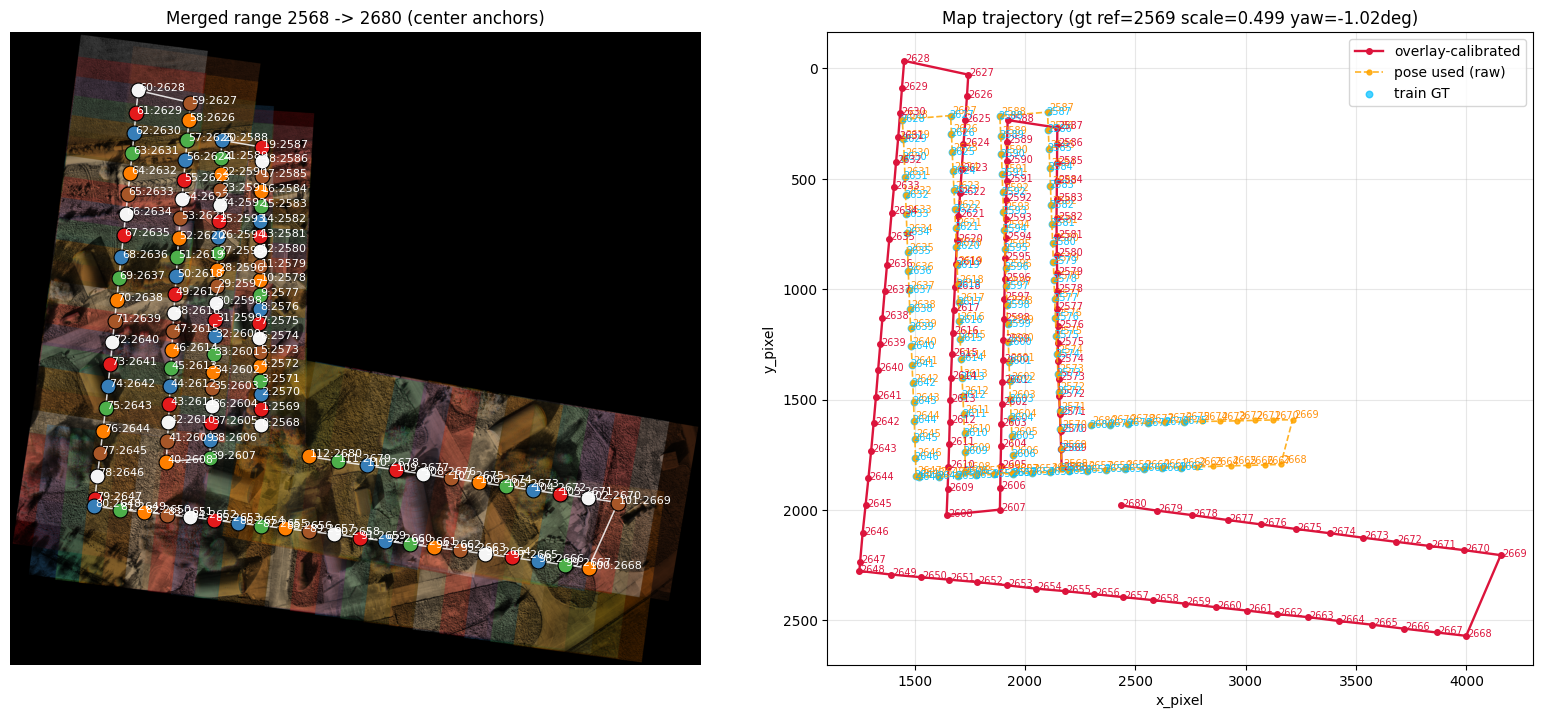

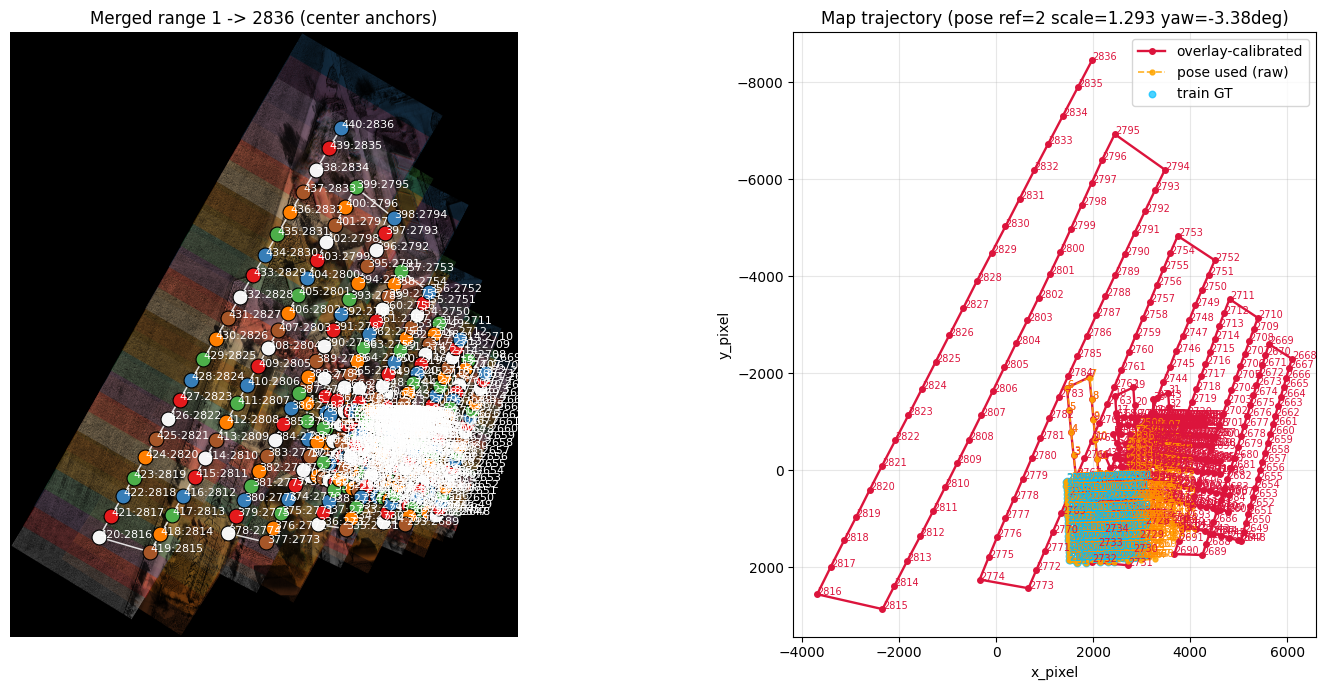

In [7]:
# Optional merged overlay visualization
sfm.plot_range(2568, 2680, validation=False)
sfm.plot_range(1, 2836, validation=False)


       id      x_pixel      y_pixel
86   2666  3008.941367  1798.673050
87   2667  3088.446307  1796.333072
88   2668  3159.096074  1794.011883
89   2669  3212.623149  1591.687013
90   2670  3124.706473  1592.582054
91   2671  3041.318388  1594.689228
92   2672  2961.840855  1596.495798
93   2673  2882.103661  1598.263554
94   2674  2802.940590  1599.259455
95   2705  2781.589880  1391.961195
96   2706  2856.162708  1386.303802
97   2707  2936.414422  1380.470488
98   2708  3018.983900  1374.692226
99   2709  3095.145679  1369.243701
100  2710  3168.892158  1364.333896
101  2711  3202.475694  1161.434176
102  2712  3109.288954  1165.795258
103  2713  3025.964076  1171.439411
104  2714  2944.791912  1177.335219
105  2715  2861.232054  1183.440757
106  2716  2785.512984  1188.566768
107  2747  2773.314871   992.676753
108  2748  2851.365539   992.294297
109  2749  2926.580305   990.979711
110  2750  3005.452126   991.586665
111  2751  3084.896313   992.592350
112  2752  3158.552441   993

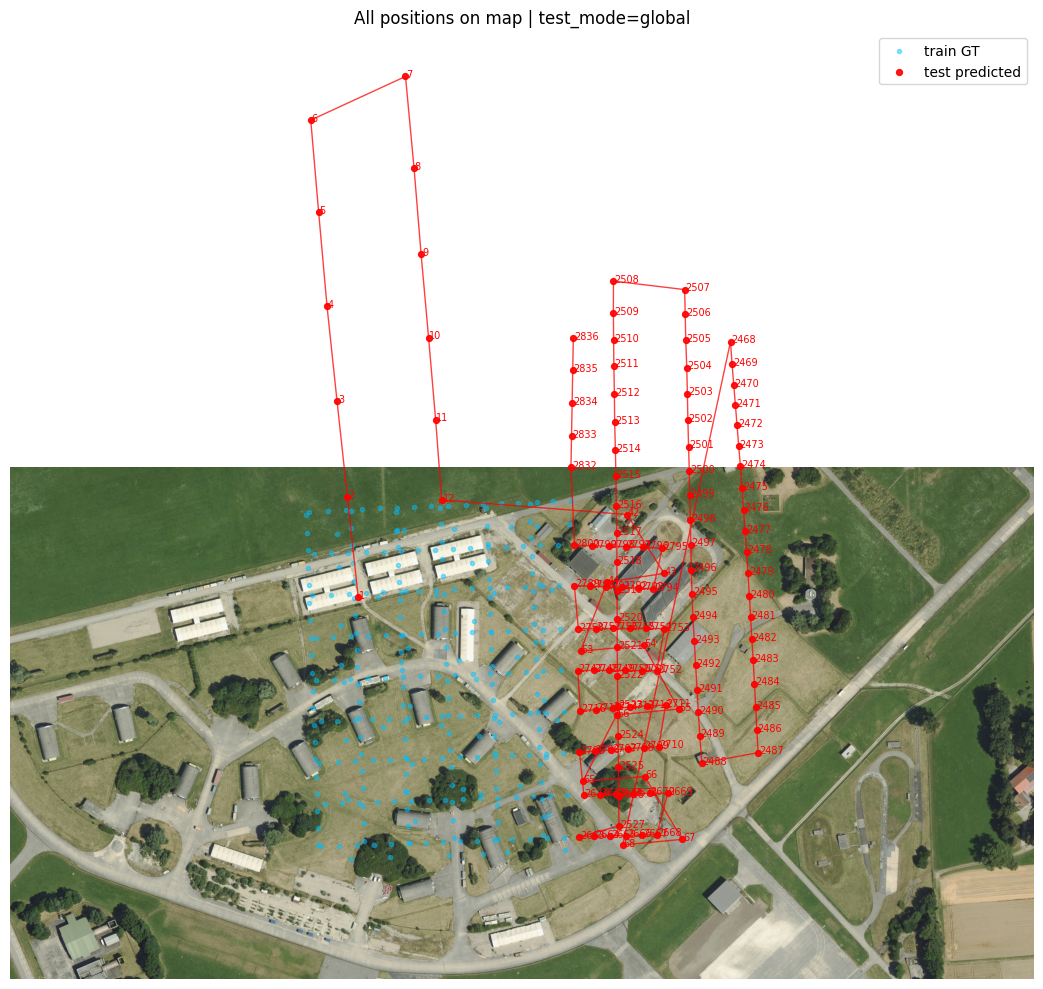

In [8]:
sfm.forward_test_set()
csv = sfm.export_submission_csv("submission_sfm.csv")
print(csv.tail(50))
sfm.plot_all_positions_on_map(show_labels=True)
